## Try and find song lyrings based on genre

In [105]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [106]:
music_df = pd.read_csv('sample_data.csv')

In [109]:
corpus = music_df['lyrics']

## Regular NLP
* Remove Names and places from corpus
* add some basic stopwords to the stop word list

In [110]:
import nltk
## Remove proper nouns
nltk.download('averaged_perceptron_tagger')
new_corp = []
for lyric in corpus:
  tagged_lyric = nltk.tag.pos_tag(str(lyric).split())
  edited_lyric = [word for word,tag in tagged_lyric if tag != 'NNP' and tag != 'NNPS']
  new_corp.append(' '.join(edited_lyric))
df = pd.DataFrame(new_corp,columns=['lyrics'])

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sibongiletoure/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [111]:
 corpus = df['lyrics']

In [112]:
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['see', 'look', 'tell', 'make', 'use','do','go']
stopwords.extend(newStopWords)
stop_words = set(stopwords)

In [113]:
from sklearn.feature_extraction.text import CountVectorizer
import pickle
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import TreebankWordTokenizer
from autocorrect import Speller

class NLPPipe:
   
    def __init__(self, vectorizer=CountVectorizer(), tokenizer=None, cleaning_function=None, 
                 lemmatizer=None,model=None):
        if not tokenizer:
            tokenizer = self.splitter
        if not cleaning_function:
            cleaning_function = self.clean_text
        self.lemmatizer = lemmatizer
        self.tokenizer = tokenizer
        self.model = model
        self.cleaning_function = cleaning_function
        self.vectorizer = vectorizer
        self._is_fit = False
        
    def splitter(self, text):
        return text.split(' ')
        
    
    def fit_transform(self, text):
        clean_text = self.cleaning_function(text, self.tokenizer, self.lemmatizer)
        return self.vectorizer.fit_transform(clean_text)

In [114]:
def clean_text(text, tokenizer, lemmatizer):
    text=text.str.replace(r'\d+','')
    text=text.replace(r'[^A-Za-z0-9 ]+', '', regex=True)
    cleaned_text = []
    for post in text:
        cleaned_words = []
        for word in tokenizer(post):
            low_word = word.lower()
            if lemmatizer:
                low_word = lemmatizer.lemmatize(low_word)
            cleaned_words.append(low_word)
        cleaned_text.append(' '.join(cleaned_words))
    return cleaned_text

In [115]:
nlp = NLPPipe(vectorizer=CountVectorizer(stop_words = stop_words,max_df=0.8), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

count_result = nlp.fit_transform(corpus)

In [116]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

##  Try LDA with a max_df of 0.8

In [117]:
from sklearn.decomposition import LatentDirichletAllocation
lda_tf = LatentDirichletAllocation(n_components=10, random_state=0)
lda_tf.fit(count_result)
display_topics(lda_tf, nlp.vectorizer.get_feature_names(), 10)


Topic  0
rock, song, sing, like, people, come, one, hand, music, hear

Topic  1
come, youre, home, baby, back, run, around, like, round, shake

Topic  2
yeah, baby, time, oh, night, good, girl, way, get, feel

Topic  3
wa, said, never, could, man, time, one, would, like, back

Topic  4
got, oh, little, get, hey, ta, girl, know, dont, want

Topic  5
na, gon, wan, la, back, got, take, town, blue, dont

Topic  6
like, nigga, bitch, got, shit, yeah, fuck, aint, dont, back

Topic  7
get, like, know, got, dont, aint, ya, let, man, em

Topic  8
eye, away, dream, sky, light, day, night, like, one, sun

Topic  9
love, know, dont, want, cant, never, need, heart, let, say


### Not very clear topics lower the max_df to 0.5

In [118]:
nlp = NLPPipe(vectorizer=CountVectorizer(stop_words = stop_words,max_df=0.5), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

count_result = nlp.fit_transform(corpus)

In [119]:
from sklearn.decomposition import LatentDirichletAllocation
lda_tf = LatentDirichletAllocation(n_components=10, random_state=0)
lda_tf.fit(count_result)
display_topics(lda_tf, nlp.vectorizer.get_feature_names(), 10)


Topic  0
wa, night, come, eye, oh, blue, like, fire, sky, rain

Topic  1
love, dont, oh, want, say, need, yeah, got, feel, like

Topic  2
want, life, alive, bit, live, little, light, dead, mind, like

Topic  3
yeah, la, hey, good, rock, ah, get, ready, roll, come

Topic  4
na, gon, get, cant, back, dont, come, right, youre, say

Topic  5
baby, let, time, tonight, dont, woman, keep, like, got, one

Topic  6
away, never, way, day, heart, time, take, one, like, world

Topic  7
like, nigga, got, get, shit, bitch, aint, dont, yeah, fuck

Topic  8
got, wa, one, man, like, get, dont, time, said, aint

Topic  9
na, girl, wan, got, like, dance, boy, little, get, move


## Add some more stopwords in english and spanish
* Try LDA with a min_df of 0.01 and using CountVectorizer

In [120]:
spanish_stopwords = nltk.corpus.stopwords.words('spanish')
newStopWords = ['oh', 'we', 'she', 'are', 'by','gim','da','at','see', 'look', 'tell', 'make', 'use','do','go']
stopwords.extend(newStopWords)
stopwords.extend(spanish_stopwords)
stop_words = set(stopwords)

In [121]:
nlp = NLPPipe(vectorizer=CountVectorizer(stop_words = stop_words,min_df=0.01), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

count_result = nlp.fit_transform(corpus)

In [122]:
from sklearn.decomposition import LatentDirichletAllocation
lda_tf = LatentDirichletAllocation(n_components=10, random_state=0)
lda_tf.fit(count_result)
display_topics(lda_tf, nlp.vectorizer.get_feature_names(), 10)


Topic  0
let, take, away, cant, world, one, feel, eye, fall, inside

Topic  1
na, know, yeah, dont, wan, like, feel, love, youre, girl

Topic  2
dont, life, got, give, live, think, thing, friend, die, nothing

Topic  3
nigga, like, aint, got, bitch, shit, yeah, fuck, know, dont

Topic  4
night, way, home, day, long, away, blue, sing, song, going

Topic  5
wa, love, never, could, heart, one, would, day, like, know

Topic  6
get, like, got, man, boy, em, put, back, let, dont

Topic  7
love, baby, want, need, little, dont, girl, tonight, give, got

Topic  8
time, come, know, say, right, keep, good, woman, stop, together

Topic  9
gon, na, back, gone, got, high, youre, well, round, shes


* Try max_df of 0.5 and add a ngram_range of 1,2

In [123]:
nlp = NLPPipe(vectorizer=CountVectorizer(stop_words = stop_words,max_df=0.5,ngram_range=(1,2)), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

count_result = nlp.fit_transform(corpus)

In [124]:
from sklearn.decomposition import LatentDirichletAllocation
lda_tf = LatentDirichletAllocation(n_components=10, random_state=0)
lda_tf.fit(count_result)
display_topics(lda_tf, nlp.vectorizer.get_feature_names(), 10)


Topic  0
let, like, one, time, got, get, come, yeah, dont, way

Topic  1
never, wa, like, day, love, night, time, say, back, dont

Topic  2
like, get, got, dont, na, yeah, one, say, gon, love

Topic  3
love, want, baby, dont, never, heart, need, say, time, come

Topic  4
got, wa, girl, one, dont, get, like, back, man, say

Topic  5
na, wan, wan na, dont, baby, got, gon, love, like, gon na

Topic  6
like, na, got, gon, gon na, get, time, wa, hey, dont

Topic  7
dont, like, get, got, youre, back, cause, want, let, yeah

Topic  8
wa, like, yeah, one, away, want, cant, dont, get, time

Topic  9
nigga, like, bitch, got, dont, shit, aint, get, yeah, time


* Add in some new stopwords

In [125]:
newStopWords = ['yeah', 'na', 'wan', 'gon', 'get','aint','cant','at','see', 'look', 'tell', 'make', 'use','do','go','got']
stopwords.extend(newStopWords)
stopwords.extend(spanish_stopwords)
stop_words = set(stopwords)

In [126]:
nlp = NLPPipe(vectorizer=CountVectorizer(stop_words = stop_words,min_df=0.01,ngram_range=(1,2)), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

count_result = nlp.fit_transform(corpus)

In [127]:
from sklearn.decomposition import LatentDirichletAllocation
lda_tf = LatentDirichletAllocation(n_components=10, random_state=0)
lda_tf.fit(count_result)
display_topics(lda_tf, nlp.vectorizer.get_feature_names(), 10)


Topic  0
dont, know, come, say, never, home, dont know, right, want, need

Topic  1
let, one, world, like, light, free, new, around, bad, beat

Topic  2
away, take, give, time, going, run, long, youre, wont, dont

Topic  3
baby, hey, woman, ah, way, hey hey, baby baby, love, every, sweet

Topic  4
like, night, girl, little, tonight, youre, right, feel, know, dance

Topic  5
life, day, eye, dream, time, heart, night, come, live, sky

Topic  6
back, like, em, time, boy, man, wa, ta, rock, put

Topic  7
wa, know, said, way, thing, could, time, one, would, never

Topic  8
love, know, love love, want, need, heart, feel, good, never, one

Topic  9
like, nigga, want, bitch, shit, dont, fuck, know, money, ooh


In [128]:
nlp = NLPPipe(vectorizer=CountVectorizer(stop_words = stop_words,max_df=0.5,ngram_range=(1,2)), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

count_result = nlp.fit_transform(corpus)

In [129]:
from sklearn.decomposition import LatentDirichletAllocation
lda_tf = LatentDirichletAllocation(n_components=10, random_state=0)
lda_tf.fit(count_result)
display_topics(lda_tf, nlp.vectorizer.get_feature_names(), 10)


Topic  0
like, dont, back, never, wa, love, want, baby, youre, nigga

Topic  1
love, like, wa, dont, time, want, one, man, hey, take

Topic  2
good, one, like, right, wa, love, time, dont, youre, come

Topic  3
dont, like, baby, time, say, love, night, want, wa, way

Topic  4
love, like, dont, let, come, baby, time, way, never, youre

Topic  5
love, like, one, dont, take, love love, say, wa, away, still

Topic  6
one, need, dont, way, man, ah, time, love, come, let

Topic  7
want, like, dont, one, away, give, say, time, baby, never

Topic  8
like, wa, come, time, one, take, love, dont, back, light

Topic  9
like, feel, love, say, time, let, dont, way, want, wa


## NMF

In [130]:
newStopWords = ['way', 'wa', 'say', 'gon', 'ill','youre','well','let','ooh']
stopwords.extend(newStopWords)
stop_words = set(stopwords)

In [133]:
nlp = NLPPipe(vectorizer=CountVectorizer(stop_words = stop_words,max_df=0.5,ngram_range=(1,2)), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

count_result = nlp.fit_transform(corpus)

In [134]:
from sklearn.decomposition import NMF
nmf_model = NMF(5)
doc_topic = nmf_model.fit_transform(count_result)

In [135]:
display_topics(nmf_model, nlp.vectorizer.get_feature_names(), 10)


Topic  0
time, one, never, back, come, take, day, night, right, life

Topic  1
love, love love, heart, need, give, feel, still, never, know love, girl

Topic  2
like, nigga, bitch, shit, like like, fuck, back, cause, feel, em

Topic  3
baby, baby baby, girl, want, come, little, shake, need, good, take

Topic  4
dont, want, dont know, need, dont want, nigga, cause, give, dont dont, think


In [136]:
nlp = NLPPipe(vectorizer=CountVectorizer(stop_words = stop_words,max_df=0.5,ngram_range=(1,2)), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

count_result = nlp.fit_transform(corpus)

In [137]:
lda_tf = LatentDirichletAllocation(n_components=10, random_state=0)
lda_tf.fit(count_result)
display_topics(lda_tf, nlp.vectorizer.get_feature_names(), 10)


Topic  0
love, like, hey, girl, one, dont, thing, wont, want, away

Topic  1
dont, like, come, time, baby, one, day, away, feel, right

Topic  2
love, like, baby, want, dont, nigga, one, time, need, feel

Topic  3
one, dont, like, time, heart, never, take, want, nigga, cause

Topic  4
like, love, dont, time, one, man, home, away, could, eye

Topic  5
love, time, dont, take, little, said, want, one, baby, like

Topic  6
like, love, baby, dont, take, time, never, want, one, girl

Topic  7
like, dont, love, baby, come, need, night, day, time, never

Topic  8
like, never, dont, back, right, one, want, life, cause, could

Topic  9
time, good, love, one, like, dont, take, world, never, come


## Use Tfidf as vectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

class NLPPipe:
   
    def __init__(self, vectorizer= TfidfVectorizer(), tokenizer=None, cleaning_function=None, 
                 lemmatizer=None,model=None):
        if not tokenizer:
            tokenizer = self.splitter
        if not cleaning_function:
            cleaning_function = self.clean_text
        self.lemmatizer = lemmatizer
        self.tokenizer = tokenizer
        self.model = model
        self.cleaning_function = cleaning_function
        self.vectorizer = vectorizer
        self._is_fit = False
        
    def splitter(self, text):
        return text.split(' ')
        
 
    
    def fit_transform(self, text):
        clean_text = self.cleaning_function(text, self.tokenizer, self.lemmatizer)
        return self.vectorizer.fit_transform(clean_text)

In [ ]:
nlp = NLPPipe(vectorizer=TfidfVectorizer(stop_words = stop_words,max_df=0.5,ngram_range=(1,2)), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

tf_result = nlp.fit_transform(corpus)

In [ ]:
lda_tf = LatentDirichletAllocation(n_components=10, random_state=0)
lda_tf.fit(tf_result)
display_topics(lda_tf, nlp.vectorizer.get_feature_names(), 10)

In [62]:
nlp = NLPPipe(vectorizer=TfidfVectorizer(stop_words = stop_words,min_df=0.01,ngram_range=(1,2)), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

tf_result = nlp.fit_transform(corpus)

In [63]:
lda_tf = LatentDirichletAllocation(n_components=10, random_state=0)
lda_tf.fit(tf_result)
display_topics(lda_tf, nlp.vectorizer.get_feature_names(), 10)


Topic  0
love, eye, one, life, day, come, dream, night, im, away

Topic  1
song, sing, music, ah, come, beautiful, love, come come, wonderful, never

Topic  2
nigga, im, like, bitch, shit, fuck, dont, know, cause, em

Topic  3
little, little bit, bit, higher, shut, run, turn, sugar, round, late

Topic  4
love, baby, love love, dont, im, know, want, need, heart, girl

Topic  5
shes, blue, home, come, im, dance, girl, back, baby, lady

Topic  6
hey, baby, hey hey, im, tonight, like, right, dont, rock, girl

Topic  7
dont, know, want, im, dont know, girl, dont want, baby, know know, woman

Topic  8
im, love, know, time, dont, never, ive, like, could, one

Topic  9
im, man, old, said, like, back, one, dont, boy, home


In [68]:
from sklearn.decomposition import NMF
nmf_model = NMF(5)
doc_topic = nmf_model.fit_transform(tf_result)

In [69]:
display_topics(nmf_model, nlp.vectorizer.get_feature_names(), 10)


Topic  0
time, one, day, come, never, life, night, away, like, back

Topic  1
love, love love, heart, true, need, know love, give, love like, feel, never

Topic  2
im, nigga, like, bitch, shit, fuck, em, cause, back, money

Topic  3
baby, baby baby, hey, girl, come, hey hey, im, little, baby dont, love baby

Topic  4
dont, know, want, dont know, dont want, need, im, know know, cause, know dont


#### * Extend stop words again

In [70]:
newStopWords = ['im', 'ah', 'em']
stopwords.extend(newStopWords)
stop_words = set(stopwords)

In [71]:
nlp = NLPPipe(vectorizer=TfidfVectorizer(stop_words = stop_words,min_df=0.01,ngram_range=(1,2)), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              lemmatizer = WordNetLemmatizer())

tf_result = nlp.fit_transform(corpus)

#### Reduce the number of LDA topics

In [72]:
lda_tf = LatentDirichletAllocation(n_components=5, random_state=0)
lda_tf.fit(tf_result)
display_topics(lda_tf, nlp.vectorizer.get_feature_names(), 10)


Topic  0
love, day, one, night, come, like, away, life, eye, time

Topic  1
hey, dont, like, want, man, know, little, girl, right, rock

Topic  2
love, dont, know, never, time, heart, one, want, ive, feel

Topic  3
baby, love, come, girl, dont, know, love love, woman, baby baby, shes

Topic  4
nigga, like, bitch, shit, fuck, dont, know, cause, back, money


In [75]:
from sklearn.decomposition import NMF
nmf_model = NMF(5)
doc_topic = nmf_model.fit_transform(tf_result)

In [76]:
display_topics(nmf_model, nlp.vectorizer.get_feature_names(), 10)


Topic  0
dont, time, one, never, like, come, away, want, ive, day

Topic  1
love, love love, know love, heart, need, love dont, true, give, love like, love know

Topic  2
baby, baby baby, want, dont, girl, baby dont, come, love baby, need, baby love

Topic  3
hey, hey hey, alright, girl, hey dont, hey baby, ra, hey little, little, right

Topic  4
nigga, bitch, like, shit, fuck, money, dont, cause, uh, thats


## Try Porter stemmer

In [139]:
from sklearn.feature_extraction.text import CountVectorizer
import pickle 
from nltk.tokenize import TreebankWordTokenizer
from autocorrect import Speller
from nltk.stem import PorterStemmer

class NLPPipe:
   
    def __init__(self, vectorizer=CountVectorizer(), tokenizer=None, cleaning_function=None, 
                 stemmer=None,model=None):
        if not tokenizer:
            tokenizer = self.splitter
        if not cleaning_function:
            cleaning_function = self.clean_text
        self.stemmer = stemmer
        self.tokenizer = tokenizer
        self.model = model
        self.cleaning_function = cleaning_function
        self.vectorizer = vectorizer
        self._is_fit = False
        
    def splitter(self, text):
        return text.split(' ')
        
 
    
    def fit_transform(self, text):
        clean_text = self.cleaning_function(text, self.tokenizer, self.stemmer)
        return self.vectorizer.fit_transform(clean_text)

In [140]:
def clean_text(text, tokenizer, stemmer):
        text=text.str.replace(r'\d+','')
        text=text.replace(r'[^A-Za-z0-9 ]+', '', regex=True)
        cleaned_text = []
        for post in text:
            cleaned_words = []
            for word in tokenizer(post):
                low_word = word.lower()
                if stemmer:
                    low_word = stemmer.stem(low_word)
                    #low_word = speller(low_word)
                cleaned_words.append(low_word)
            cleaned_text.append(' '.join(cleaned_words))
        return cleaned_text

In [90]:
nlp = NLPPipe(vectorizer=CountVectorizer(stop_words = stop_words,min_df=0.01,ngram_range=(1,2)), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              stemmer = PorterStemmer())

count_result = nlp.fit_transform(corpus)

In [91]:
nmf_model = NMF(5)
doc_topic = nmf_model.fit_transform(count_result)

In [92]:
display_topics(nmf_model, nlp.vectorizer.get_feature_names(), 10)


Topic  0
thi, time, one, come, day, like, never, night, away, life

Topic  1
love, love love, heart, true, need, feel, give, fall love, know love, love like

Topic  2
nigga, like, bitch, fuck, shit, thi, ass, money, caus, back

Topic  3
babi, babi babi, hey, girl, come, hey hey, littl, love babi, babi dont, good

Topic  4
dont, know, want, dont know, need, dont want, whi, caus, think, girl


In [93]:
lda_count = LatentDirichletAllocation(n_components=5, random_state=0)
lda_count.fit(tf_result)
display_topics(lda_count, nlp.vectorizer.get_feature_names(), 10)


Topic  0
hi, man, one, thi, like, said, dont, know, old, time

Topic  1
love, know, dont, never, time, thi, feel, heart, want, one

Topic  2
love, away, come, night, light, dream, like, thi, day, eye

Topic  3
babi, hey, love, girl, want, come, dont, littl, know, good

Topic  4
nigga, like, fuck, bitch, shit, dont, thi, know, caus, back


## Ngrams seem to be pretty repetitive will not use them

In [94]:
nlp = NLPPipe(vectorizer=CountVectorizer(stop_words = stop_words,min_df=0.01), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              stemmer = PorterStemmer())

count_result = nlp.fit_transform(corpus)

In [111]:
nmf_model = NMF(5)
doc_topic = nmf_model.fit_transform(count_result)

In [112]:
display_topics(nmf_model, nlp.vectorizer.get_feature_names(), 10)


Topic  0
time, thi, one, come, day, never, like, night, away, life

Topic  1
love, heart, true, need, give, feel, fall, never, kiss, alway

Topic  2
babi, girl, hey, come, littl, good, right, like, tonight, babe

Topic  3
nigga, like, bitch, fuck, shit, thi, ass, money, caus, back

Topic  4
dont, know, want, need, whi, caus, think, girl, tri, care


In [113]:
lda_count = LatentDirichletAllocation(n_components=6, random_state=0)
lda_count.fit(count_result)
display_topics(lda_tf, nlp.vectorizer.get_feature_names(), 10)


Topic  0
dont, know, time, thi, love, never, ive, like, feel, think

Topic  1
love, heart, know, babi, dont, never, one, dream, thi, time

Topic  2
man, hi, dont, old, like, come, back, rock, said, one

Topic  3
nigga, like, fuck, bitch, shit, dont, thi, know, caus, back

Topic  4
love, come, thi, like, light, night, day, away, sky, eye

Topic  5
babi, love, dont, hey, girl, want, know, like, come, good


 ## Topics pretty clear will try genism

In [127]:
count_result.T.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.03333985, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [128]:
from gensim import interfaces, utils, matutils
corpus = matutils.Sparse2Corpus(count_result.T)
id2word = dict((v, k) for k, v in nlp.vectorizer.vocabulary_.items())

In [129]:
import gensim
import gensim.corpora as corpora
from gensim import interfaces, utils, matutils

corpus = matutils.Sparse2Corpus(count_result.transpose())
id2word = dict((v, k) for k, v in nlp.vectorizer.vocabulary_.items())

lda_genism = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=0)

In [130]:
lda_genism.print_topics()

[(0,
  '0.019*"love" + 0.012*"know" + 0.011*"dont" + 0.009*"time" + 0.009*"never" + 0.008*"thi" + 0.007*"heart" + 0.007*"feel" + 0.007*"one" + 0.007*"want"'),
 (1,
  '0.015*"love" + 0.011*"dont" + 0.011*"know" + 0.007*"ive" + 0.007*"babi" + 0.007*"want" + 0.007*"time" + 0.006*"live" + 0.006*"one" + 0.006*"world"'),
 (2,
  '0.008*"thi" + 0.007*"fire" + 0.007*"take" + 0.007*"dont" + 0.007*"run" + 0.006*"like" + 0.006*"burn" + 0.006*"one" + 0.006*"know" + 0.006*"life"'),
 (3,
  '0.012*"like" + 0.012*"nigga" + 0.008*"dont" + 0.008*"fuck" + 0.007*"know" + 0.007*"thi" + 0.007*"bitch" + 0.007*"shit" + 0.006*"back" + 0.006*"man"'),
 (4,
  '0.008*"love" + 0.007*"come" + 0.007*"hi" + 0.006*"day" + 0.006*"night" + 0.006*"away" + 0.005*"rain" + 0.005*"dream" + 0.005*"light" + 0.005*"sun"'),
 (5,
  '0.030*"babi" + 0.025*"love" + 0.015*"girl" + 0.015*"dont" + 0.014*"hey" + 0.013*"want" + 0.012*"know" + 0.010*"come" + 0.009*"like" + 0.009*"littl"')]

## Try a tSne plot on lda w/o genism

In [107]:
topic_values = lda_count.transform(count_result)
topic_values

array([[0.83357543, 0.03327575, 0.03336938, 0.03319872, 0.03328766,
        0.03329305],
       [0.85990578, 0.02803122, 0.02792066, 0.02816411, 0.02797633,
        0.02800189],
       [0.82548606, 0.03490305, 0.03506052, 0.03478598, 0.03473165,
        0.03503274],
       ...,
       [0.02942617, 0.02945572, 0.85254493, 0.02938972, 0.02944043,
        0.02974304],
       [0.03361454, 0.03365927, 0.03364959, 0.03358585, 0.83191659,
        0.03357415],
       [0.05251138, 0.05269245, 0.05246349, 0.05254272, 0.05235973,
        0.73743023]])

In [109]:

df = pd.DataFrame(topic_values.round(5),
             index = music_df.name,
             columns = ["topic_1","topic_2","topic_3",'topic_4','topic_5',\
                       'topic_6'])

In [110]:
df

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
name,,,,,,
I Can't See Your Face in My Mind,0.83358,0.03328,0.03337,0.03320,0.03329,0.03329
I Could Have Lied,0.85991,0.02803,0.02792,0.02816,0.02798,0.02800
The Letter - Mono Single Version,0.82549,0.03490,0.03506,0.03479,0.03473,0.03503
Promises - Skrillex & Nero Remix,0.76080,0.04802,0.04768,0.04766,0.04794,0.04790
"Oh No, Babe",0.02632,0.02628,0.02645,0.86825,0.02638,0.02632
...,...,...,...,...,...,...
I've Been Loving You Too Long - Live in Europe; 2008 Remaster,0.02458,0.51326,0.02454,0.02452,0.02456,0.38854
Fazers,0.01748,0.01746,0.01750,0.77963,0.15048,0.01744
Wolfman Jack,0.02943,0.02946,0.85254,0.02939,0.02944,0.02974


In [142]:
maxValues = df.idxmax(axis=1)

In [143]:
dfdf['dominant_topic'] = maxValues

<AxesSubplot:>

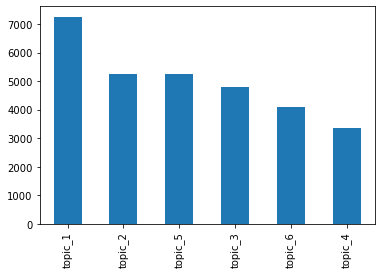

In [144]:
df['dominant_topic'].value_counts().plot(kind='bar')

In [174]:
X= df[['topic_1','topic_2','topic_3','topic_4','topic_5','topic_6']]

In [175]:
target = df.dominant_topic

In [176]:
target_name = list(target.unique())

In [177]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, random_state=42)
tsne_data = tsne_model.fit_transform(X)

In [178]:
def plot_tsne(data, target, target_names):
    color=["yellow", "forestgreen", "skyblue", "royalblue", "black", "red", "purple"]
    for c, label in zip(color, target_names):
        plt.scatter(data[target == label, 0], data[target == label, 1], c=c, label=label, s=0.4, alpha=0.5)
    plt.legend(fontsize=6, loc='upper left', frameon=True, facecolor='#FFFFFF', edgecolor='#333333')
    plt.xlim(-100,100)
    plt.grid(b=None);

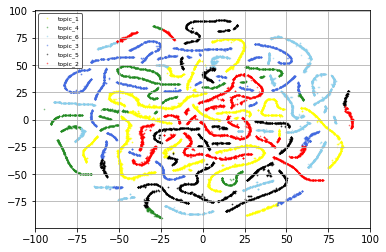

In [179]:
plot_tsne(tsne_data,target,target_name)

## LDA w/genism

In [131]:
doc_topic = [lda_genism.get_document_topics(item) for item in corpus]

In [132]:
topic_dicts = [dict(doc) for doc in doc_topic]

In [133]:
gen_df = pd.DataFrame(topic_dicts,
             index = music_df.name)
gen_df = gen_df.fillna(0)

In [134]:
gen_df

,0,1,2,3,4,5
name,,,,,,
I Can't See Your Face in My Mind,0.832165,0.033277,0.033509,0.033871,0.033897,0.033282
I Could Have Lied,0.859320,0.028029,0.028148,0.028514,0.027977,0.028012
The Letter - Mono Single Version,0.034890,0.825812,0.034713,0.034809,0.034879,0.034897
Promises - Skrillex & Nero Remix,0.760943,0.047719,0.047973,0.047690,0.047856,0.047819
"Oh No, Babe",0.026259,0.026292,0.026313,0.868528,0.026327,0.026282
...,...,...,...,...,...,...
I've Been Loving You Too Long - Live in Europe; 2008 Remaster,0.024652,0.024639,0.024603,0.024519,0.024569,0.877018
Fazers,0.017470,0.017487,0.017534,0.912493,0.017589,0.017426
Wolfman Jack,0.029435,0.029412,0.029518,0.597259,0.029682,0.284693


In [136]:
gen_df.rename(columns={0:'topic_1',1:'topic_2',2:'topic_3',3:'topic_4',4:'topic_5',5:'topic_6'},inplace=True)

In [137]:
maxValues = gen_df.idxmax(axis=1)

In [139]:
gen_df['dominant_topic'] = maxValues

<AxesSubplot:>

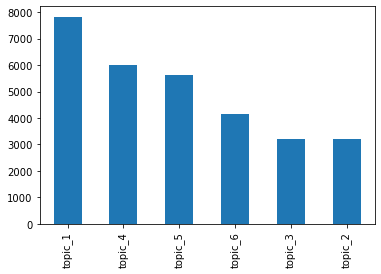

In [141]:
gen_df['dominant_topic'].value_counts().plot(kind='bar')

In [190]:
X= gen_df[['topic_1','topic_2','topic_3','topic_4','topic_5','topic_6']]

In [191]:
tsne_model = TSNE(n_components=2,perplexity=50, random_state=42)
tsne_data = tsne_model.fit_transform(X)

In [192]:
target = gen_df.dominant_topic

In [193]:
target_name = list(target.unique())

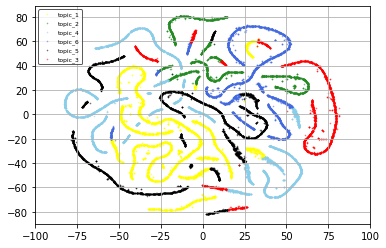

In [194]:
plot_tsne(tsne_data,target,target_name)

In [161]:
music_df[music_df['name']=='I Burn For You - Live In Arnhem']['lyrics'].item()

'Now that i have found you In the coolth of your evening smile The shade of your parasol And your love flows through me Though i drink at your pool I burn for you, i burn for You and i are lovers When night time folds around our bed In peace we sleep entwined And your love flows through me Though an ocean soothes my head I burn for you, i burn for Stars will fall from dark skies As ancient rocks are turning Quiet fills the room And your love flows through me Though i lie here so still I burn for you, i burn for you I burn'

In [162]:
gen_df[gen_df['dominant_topic']=='topic_4']

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,dominant_topic
name,,,,,,,
"Oh No, Babe",0.026259,0.026292,0.026313,0.868528,0.026327,0.026282,topic_4
Trashed - 2004 Remaster,0.022427,0.022465,0.346033,0.564244,0.022467,0.022365,topic_4
Lucus Was A Redneck,0.026888,0.026813,0.026868,0.865682,0.026962,0.026786,topic_4
Hominy Grits,0.028242,0.253215,0.028298,0.633699,0.028277,0.028270,topic_4
Rich Girl,0.370936,0.024006,0.023868,0.533225,0.023887,0.024078,topic_4
...,...,...,...,...,...,...,...
What Ya Want,0.021519,0.021487,0.021500,0.497229,0.021443,0.416823,topic_4
claws,0.044077,0.043714,0.043490,0.781171,0.043794,0.043753,topic_4
"Come, Gone",0.020462,0.020485,0.020613,0.897397,0.020636,0.020407,topic_4


## Play around with NMF a bit more

In [181]:
corpus = music_df['lyrics']

In [141]:
nlp = NLPPipe(vectorizer=TfidfVectorizer(stop_words = stop_words,min_df=0.01), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              stemmer = PorterStemmer())

tf_result = nlp.fit_transform(corpus)

In [142]:
nmf_model = NMF(5)
doc_topic = nmf_model.fit_transform(tf_result)

In [143]:
display_topics(nmf_model, nlp.vectorizer.get_feature_names(), 10)


Topic  0
thi, time, one, come, day, away, night, never, hi, life

Topic  1
love, heart, true, give, need, feel, fall, never, kiss, alway

Topic  2
nigga, like, bitch, shit, fuck, thi, em, ass, back, money

Topic  3
babi, girl, come, littl, good, hey, tonight, right, babe, alright

Topic  4
dont, know, want, need, whi, think, feel, caus, girl, tri


In [144]:
nlp = NLPPipe(vectorizer=CountVectorizer(stop_words = stop_words,max_df=0.5), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              stemmer = PorterStemmer())

count_result = nlp.fit_transform(corpus)

In [145]:
display_topics(nmf_model, nlp.vectorizer.get_feature_names(), 10)


Topic  0
ajumpin, akiss, aggi, abrir, ac, aactin, againyesterday, agains, admit, affectin

Topic  1
afing, adjustin, alaykum, acuffros, againoh, acompanado, acknowledg, agains, advocaci, aaaaay

Topic  2
againyeah, affi, abandonedli, ahhuh, action, ajumpin, acendeu, aaat, aahaah, afternoon

Topic  3
aah, acuerda, abrir, affirm, adaptor, admiss, alabam, ahangin, aafter, aaaaahhhahah

Topic  4
accolad, aeat, alentour, againoh, alig, ajust, acompanado, abondon, acuerda, alarm


In [146]:
nlp = NLPPipe(vectorizer=CountVectorizer(stop_words = stop_words,min_df=0.01), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              stemmer = PorterStemmer())

count_result = nlp.fit_transform(corpus)

In [147]:
nmf_model = NMF(6)
doc_topic = nmf_model.fit_transform(count_result)

In [148]:
display_topics(nmf_model, nlp.vectorizer.get_feature_names(), 10)


Topic  0
thi, time, one, come, day, away, night, never, hi, take

Topic  1
love, heart, true, give, need, feel, fall, never, kiss, alway

Topic  2
nigga, like, bitch, shit, fuck, thi, em, ass, back, money

Topic  3
babi, girl, come, littl, good, hey, tonight, right, babe, alright

Topic  4
know, dont, whi, think, feel, need, caus, tri, never, care

Topic  5
want, need, girl, give, dont, take, one, realli, caus, hold


In [149]:
nlp = NLPPipe(vectorizer=CountVectorizer(stop_words = stop_words,min_df=0.01), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              stemmer = PorterStemmer())

count_result = nlp.fit_transform(corpus)

In [150]:
nmf_model = NMF(6)
doc_topic = nmf_model.fit_transform(count_result)

In [151]:
display_topics(nmf_model, nlp.vectorizer.get_feature_names(), 10)


Topic  0
know, never, feel, whi, caus, realli, girl, think, thing, could

Topic  1
love, heart, need, feel, give, day, never, still, girl, one

Topic  2
like, nigga, bitch, shit, fuck, back, thi, em, caus, feel

Topic  3
thi, time, one, come, back, take, never, day, night, feel

Topic  4
dont, want, need, nigga, give, caus, whi, fuck, think, care

Topic  5
babi, come, girl, want, take, good, littl, right, need, shake


In [152]:
nlp = NLPPipe(vectorizer=CountVectorizer(stop_words = stop_words,min_df=0.01), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              stemmer = PorterStemmer())

count_result = nlp.fit_transform(corpus)

In [153]:
lda_count = LatentDirichletAllocation(n_components=6, random_state=0)
lda_count.fit(count_result)
display_topics(lda_count, nlp.vectorizer.get_feature_names(), 10)


Topic  0
hi, love, come, thi, like, one, day, away, eye, man

Topic  1
like, nigga, bitch, shit, dont, fuck, thi, know, back, em

Topic  2
thi, dont, know, like, time, take, life, one, live, world

Topic  3
babi, know, dont, come, love, home, woman, danc, good, like

Topic  4
love, know, dont, want, heart, never, feel, time, babi, one

Topic  5
love, song, sing, girl, hey, like, littl, blue, night, music


## Porter Stemmer with TFIDF

In [154]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle 
from nltk.tokenize import TreebankWordTokenizer
from autocorrect import Speller
from nltk.stem import PorterStemmer

class NLPPipe:
   
    def __init__(self, vectorizer=TfidfVectorizer(), tokenizer=None, cleaning_function=None, 
                 stemmer=None,model=None):
        if not tokenizer:
            tokenizer = self.splitter
        if not cleaning_function:
            cleaning_function = self.clean_text
        self.stemmer = stemmer
        self.tokenizer = tokenizer
        self.model = model
        self.cleaning_function = cleaning_function
        self.vectorizer = vectorizer
        self._is_fit = False
        
    def splitter(self, text):
        return text.split(' ')
        
 
    
    def fit_transform(self, text):
        clean_text = self.cleaning_function(text, self.tokenizer, self.stemmer)
        return self.vectorizer.fit_transform(clean_text)

In [155]:
nlp = NLPPipe(vectorizer=TfidfVectorizer(stop_words = stop_words,min_df=0.01), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              stemmer = PorterStemmer())

tf_result = nlp.fit_transform(corpus)

In [156]:
lda_tf = LatentDirichletAllocation(n_components=6, random_state=0)
lda_tf.fit(tf_result)
display_topics(lda_tf, nlp.vectorizer.get_feature_names(), 10)


Topic  0
hi, love, come, thi, like, one, day, away, eye, man

Topic  1
like, nigga, bitch, shit, dont, fuck, thi, know, back, em

Topic  2
thi, dont, know, like, time, take, life, one, live, world

Topic  3
babi, know, dont, come, love, home, woman, danc, good, like

Topic  4
love, know, dont, want, heart, never, feel, time, babi, one

Topic  5
love, song, sing, girl, hey, like, littl, blue, night, music


In [157]:
nlp = NLPPipe(vectorizer=TfidfVectorizer(stop_words = stop_words,min_df=0.01,ngram_range=(1,2)), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              stemmer = PorterStemmer())

tf_result = nlp.fit_transform(corpus)

In [158]:
lda_tf = LatentDirichletAllocation(n_components=6, random_state=0)
lda_tf.fit(tf_result)
display_topics(lda_tf, nlp.vectorizer.get_feature_names(), 20)


Topic  0
love, day, dream, come, hi, sky, night, like, eye, thi, light, heart, one, sun, away, rain, sing, moon, world, star

Topic  1
like, hi, back, danc, man, babi, night, come, rock, one, hey, said, littl, know, thi, boy, girl, old, time, home

Topic  2
love, babi, know, love love, feel, girl, want, heart, need, never, one, dont, like, give, thi, time, hold, good, littl, kiss

Topic  3
nigga, like, fuck, bitch, shit, thi, dont, know, em, back, caus, money, ass, hit, ta, one, man, put, yall, want

Topic  4
time, thi, know, away, love, feel, never, life, take, come, dont, one, heart, like, back, live, day, world, could, eye

Topic  5
dont, know, want, like, love, man, whi, think, dont know, need, babi, thing, woman, thi, time, care, good, one, caus, take


In [159]:
topic_values = lda_tf.transform(tf_result)
topic_values

array([[0.03391984, 0.03425283, 0.03395879, 0.03390535, 0.82987772,
        0.03408548],
       [0.02811002, 0.02811598, 0.02835833, 0.02829248, 0.85885561,
        0.02826758],
       [0.03647244, 0.81719033, 0.03659895, 0.03646109, 0.03662874,
        0.03664844],
       ...,
       [0.02537972, 0.87312412, 0.02544682, 0.0252826 , 0.02538948,
        0.02537726],
       [0.82102379, 0.03589551, 0.03577393, 0.0357824 , 0.03583175,
        0.03569262],
       [0.05176592, 0.05212735, 0.73975265, 0.05236427, 0.05180442,
        0.05218539]])

In [215]:

df = pd.DataFrame(topic_values.round(5),
             index = music_df.name,
             columns = ["topic_1","topic_2","topic_3",'topic_4','topic_5',\
                       'topic_6'])

In [216]:
maxValues = df.idxmax(axis=1)

In [218]:
df['dominant_topic'] = maxValues

In [219]:
df

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,dominant_topic
name,,,,,,,
I Can't See Your Face in My Mind,0.03270,0.83554,0.03265,0.03272,0.03298,0.03342,topic_2
I Could Have Lied,0.02808,0.85897,0.02812,0.02809,0.02866,0.02807,topic_2
The Letter - Mono Single Version,0.03442,0.03455,0.03435,0.03461,0.03435,0.82772,topic_6
Promises - Skrillex & Nero Remix,0.04685,0.76572,0.04702,0.04682,0.04679,0.04680,topic_2
"Oh No, Babe",0.02588,0.02583,0.02572,0.02577,0.87103,0.02577,topic_5
...,...,...,...,...,...,...,...
I've Been Loving You Too Long - Live in Europe; 2008 Remaster,0.02340,0.45593,0.02345,0.45036,0.02342,0.02344,topic_2
Fazers,0.34658,0.01736,0.01738,0.01734,0.58390,0.01744,topic_5
Wolfman Jack,0.02915,0.02910,0.02939,0.85366,0.02930,0.02938,topic_4


<AxesSubplot:>

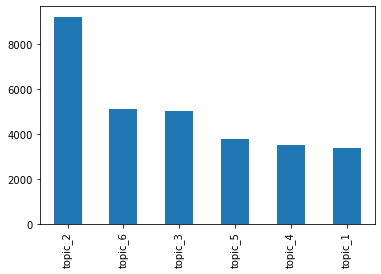

In [220]:
df['dominant_topic'].value_counts().plot(kind='bar')

In [221]:
X= df[['topic_1','topic_2','topic_3','topic_4','topic_5','topic_6']]

In [222]:
target = df['dominant_topic']

In [223]:
target_name = list(target.unique())

In [224]:
tsne_model = TSNE(n_components=2,perplexity=50, random_state=42)
tsne_data = tsne_model.fit_transform(X)

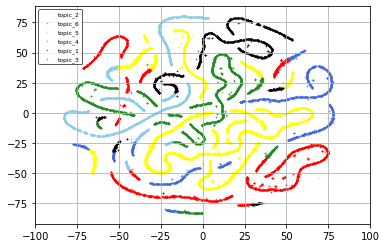

In [225]:
plot_tsne(tsne_data,target,target_name)

In [226]:
maxValues = maxValues.reset_index()

In [227]:
music_df['dominant_topic'] = maxValues[0]

In [228]:
music_df.to_csv('recommenderdata2.csv')

## Try removing this and see how topics change

In [99]:
newStopWords = ['thi','only','like','hi']
stopwords.extend(newStopWords)
stop_words = stopwords

In [100]:
nlp = NLPPipe(vectorizer=TfidfVectorizer(stop_words = stop_words,min_df=0.01), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              stemmer = PorterStemmer())

tf_result = nlp.fit_transform(corpus)

In [101]:
lda_tf = LatentDirichletAllocation(n_components=6, random_state=0)
lda_tf.fit(tf_result)
display_topics(lda_tf, nlp.vectorizer.get_feature_names(), 10)


Topic  0
love, night, light, eye, come, away, sky, fire, fli, feel

Topic  1
nigga, fuck, shit, bitch, dont, know, back, em, caus, money

Topic  2
know, dont, danc, time, said, one, littl, song, think, want

Topic  3
love, know, heart, never, time, dont, one, feel, dream, day

Topic  4
one, know, come, man, time, day, world, live, love, away

Topic  5
love, babi, know, want, dont, girl, need, feel, good, give


In [102]:
nlp = NLPPipe(vectorizer=TfidfVectorizer(stop_words = stop_words,min_df=0.01,ngram_range=(1,2)), 
              cleaning_function=clean_text, 
              tokenizer=TreebankWordTokenizer().tokenize,
              stemmer = PorterStemmer())

tf_result = nlp.fit_transform(corpus)

In [103]:
lda_tf = LatentDirichletAllocation(n_components=6, random_state=0)
lda_tf.fit(tf_result)
display_topics(lda_tf, nlp.vectorizer.get_feature_names(), 20)


Topic  0
sing, night, song, come, love, day, blue, one, old, long, sun, sky, rain, littl, away, time, home, danc, light, man

Topic  1
babi, dont, know, want, love, girl, need, feel, good, right, come, littl, dont know, tonight, take, babi babi, alright, time, know know, whi

Topic  2
love, heart, know, love love, never, feel, one, dream, time, day, need, onli, want, true, could, hold, dont, away, fall, alway

Topic  3
nigga, fuck, bitch, shit, dont, know, back, em, caus, money, man, want, hit, ass, one, put, take, come, ta, boy

Topic  4
time, know, dont, one, think, said, never, love, home, thing, man, could, back, day, come, friend, good, life, want, gone

Topic  5
away, take, know, feel, one, eye, life, world, come, run, live, time, die, fire, burn, dont, us, never, light, love
